# MTpy Example 11

## Modeling

Looking at the MT response is useful for understanding your data and generally what the data represents.  However, to get a full understanding of the subsurface we need to convert the measured MT response to an Earth response through forward modeling and inversion.  1D and 2D modeling can be done using Simpeg as presented by Seogi.  Here we will look at creating input files for ModEM.  We will create a model for just the Yellowstone area with the option of adding topography.


In [1]:
from pathlib import Path
import numpy as np
from mtpy import MTCollection

from mtpy.modeling.modem import (
    Model, Covariance, ControlFwd, ControlInv
)

%matplotlib widget

2022-10-15 14:16:05,966 [line 135] error.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\logs\mtpy_error.log
2022-10-15 14:16:05,982 [line 135] matplotlib.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\logs\matplotlib_warn.log
2022-10-15 14:16:12,007 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


### Open MTCollection

In the previous example we created a MTH5 file from existing Yellowstone data.  Let's open that file here for plotting.

In [2]:
mc = MTCollection()
mc.open_collection(Path().cwd().parent.parent.joinpath("data", "transfer_functions", "yellowstone_mt_collection.h5"))

In [3]:
mc.apply_bbox(*[-111.4, -109.85, 44, 45.2])

In [4]:
%%time
mt_data = mc.to_mt_data()

Wall time: 39.2 s


## Plot Stations

Make sure we got everything we want.  

2022-10-15T14:16:58 [line 140] rasterio._env.open - INFO: GDAL signalled an error: err_no=4, msg="`/vsimem/261d592c-7065-4783-865c-6f97d19dec7a/261d592c-7065-4783-865c-6f97d19dec7a.tif' not recognized as a supported file format."


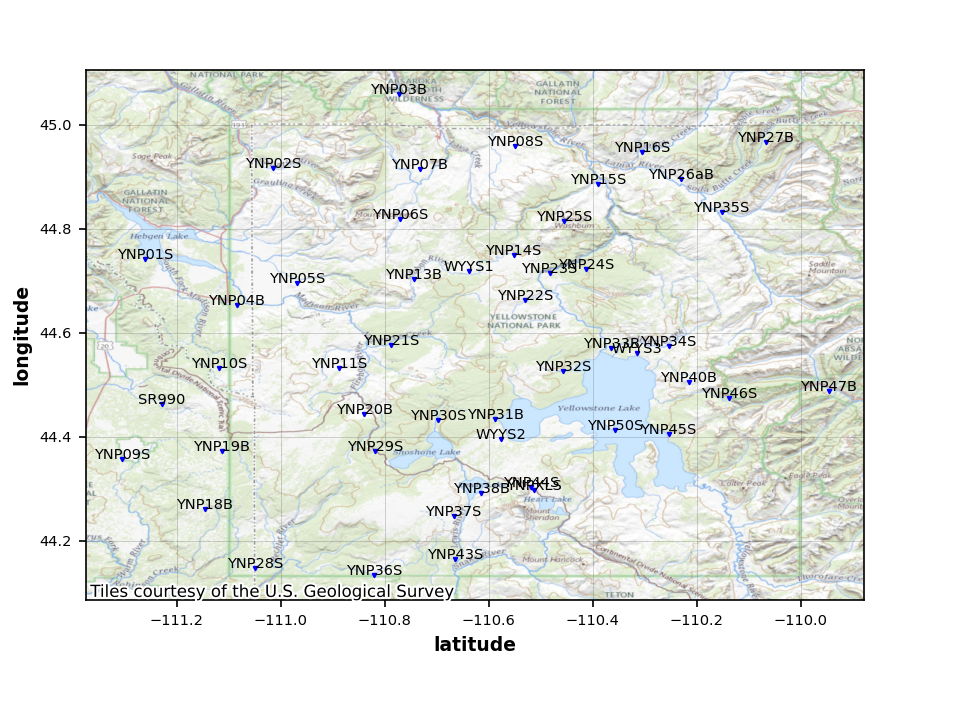

In [5]:
plot_stations = mt_data.plot_stations(fig_num=1)

## Check Stations

It looks like there are some stations close together, so we should decide which of them we should use for modeling.

- YNP44S, YNPXLS
- YNP33B, WYYS3, YNP34S


### Compare YNP44S and YNPXLS

We can plot these together and make an executive decision to keep one over the other.  From an eyeball test it appears YNPXLS is smoother in phase.  So lets keep YNPXLS and remove YNP44S

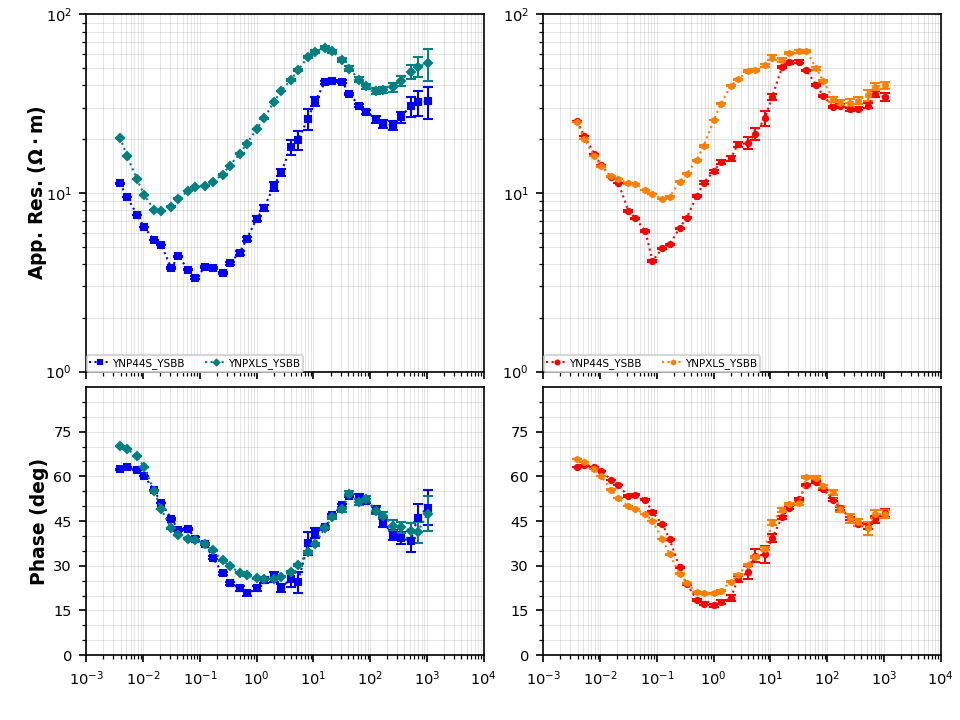

In [6]:
plot_compare = mt_data.plot_mt_response(station_id=["YNP44S", "YNPXLS"], plot_style="compare", fig_num=2)

### Compare YNP33B, WYYS3, YNP34S

It apears that YNP33B has a large static shift, and the phase is a little more noisy than YNP34.  Looks like WYYS3 is similar to YNP34S, so for this excersize we can remove WYYS3 as well because we will only use periods down to 1000 seconds.  

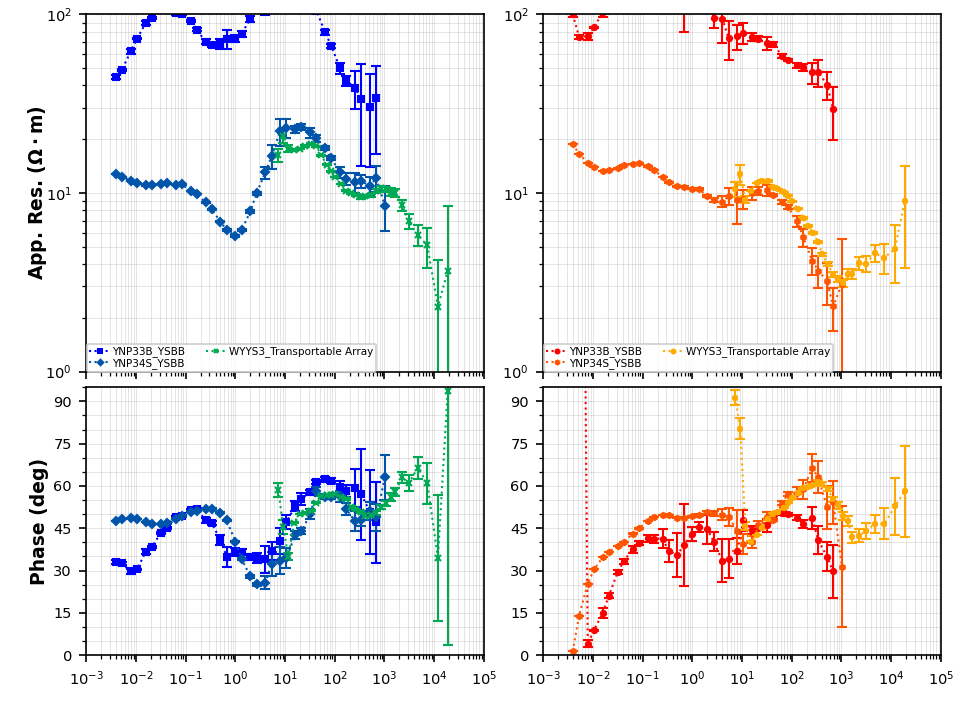

In [7]:
compare_plot_02 = mt_data.plot_mt_response(station_id=["YNP33B", "YNP34S", "WYYS3"], plot_style="compare", fig_num=4)

### Remove stations

Now that we have picked out some stations to remove let's get rid of them.

In [8]:
for station_id in ["YNP44S", "YNP33B", "WYYS3"]:
    mt_data.remove_station(station_id)

### Replot Stations

2022-10-15T14:17:09 [line 140] rasterio._env.open - INFO: GDAL signalled an error: err_no=4, msg="`/vsimem/f8630e4d-ae26-4fcd-9e2f-9f3dce7ea6fc/f8630e4d-ae26-4fcd-9e2f-9f3dce7ea6fc.tif' not recognized as a supported file format."


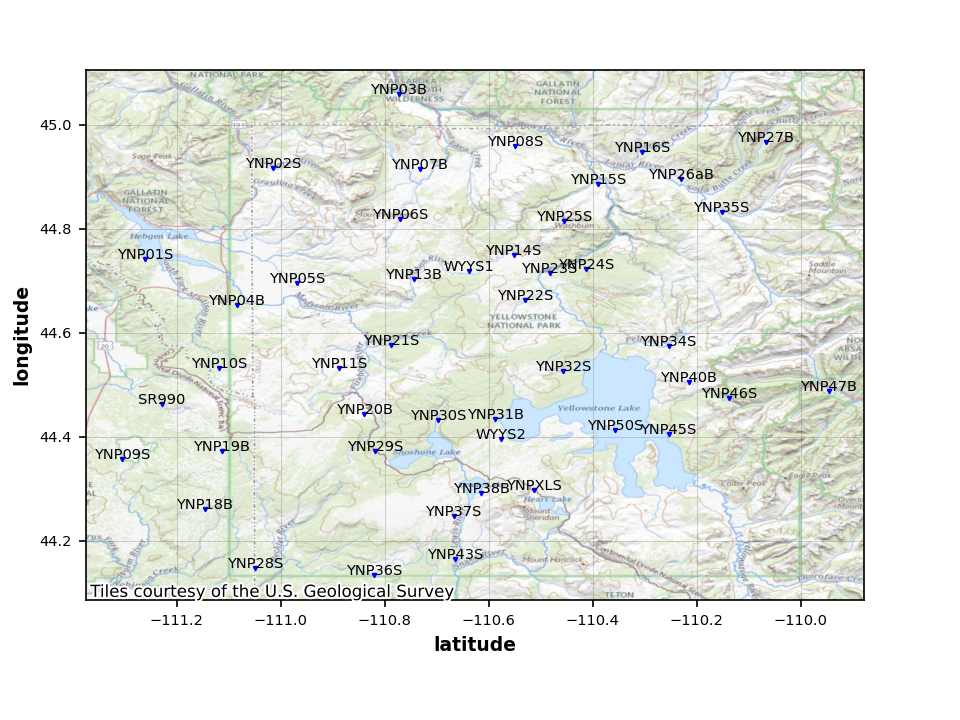

In [9]:
plot_stations_02 = mt_data.plot_stations(fig_num=5)

## Model Periods

Now that we have a decent station coverage we need to choose the periods to invert.  For 3D this is commonly decided by the computer architecture because the parallelization is often by period.  Here our compute power is limited to your desktop so lets use 10 periods over the period range (0.01, 1000).  We will use a spline interpolation for each component and both real and imaginary components.  

In [10]:
interp_periods = np.logspace(-2, 3, 10)

In [11]:
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

Just check to make sure interpolation is accurate, lets plot some stations together.

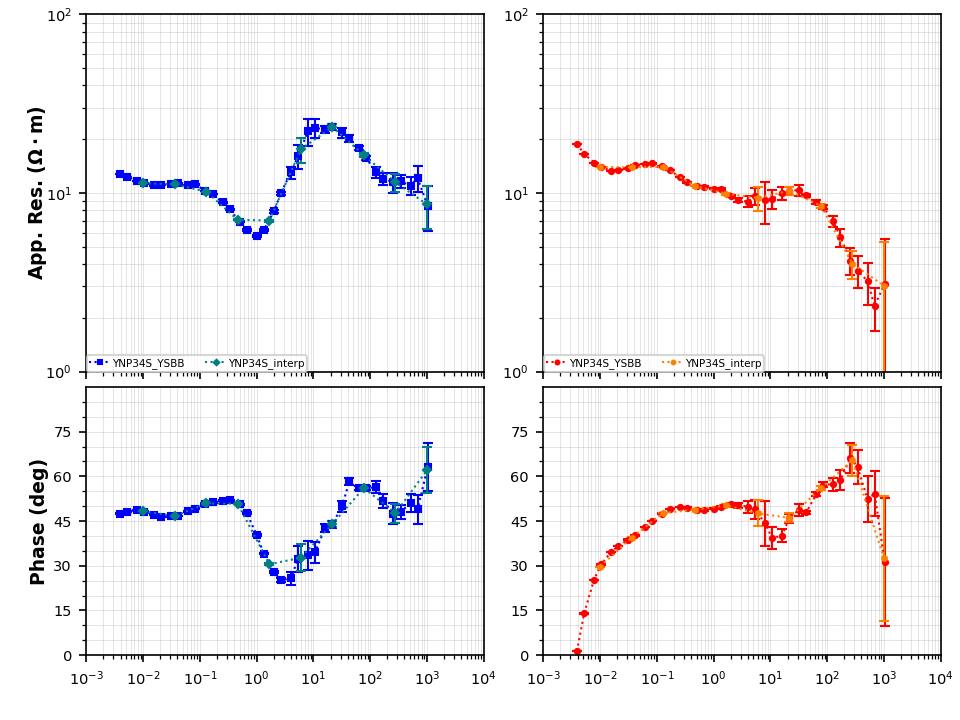

In [12]:
mt_01 = mt_data.get_subset(["YNP34S"])
mt_02 = interp_mt_data.get_station("YNP34S")
mt_02.survey = "interp"
mt_01.add_station(mt_02)

pmr = mt_01.plot_mt_response(station_key=list(mt_01.keys()), plot_style="compare", fig_num=6)

## Model Errors

Now that we have a decent station coverage we need to assigne model errors.  Typically we use some combination of the diagonal components and set an error floor of between 3 - 5%.  Below are the supported error types.

| Error Type          |    Dfinition                         |
|------------------------|---------------------------------------|
| egbert                |     error_value * sqrt(Zxy * Zyx) |
| geometric_mean        |    error_value * sqrt(Zxy * Zyx) |
| arithmetic_mean       |   error_value * (Zxy + Zyx) / 2 |
| mean_od               |     error_value * (Zxy + Zyx) / 2 |
| off_diagonals         |     zxx_err == zxy_err, zyx_err == zyy_err |
| median                |     error_value * median(z) |
| eigen                 |     error_value * mean(eigen(z)) |
| percent               |     error_value * z |
| absolute              |     error_value |

For this excersize we will use the defaults which are:

  - Impedance
     - `error_type = 'geometric_mean'`
     - `error_value = 0.05`
     - `floor = True`
  - Tipper
     - `error_type = 'absolute'`
     - `error_value = 0.02`
     - `floor = True`
     

In [13]:
interp_mt_data.compute_model_errors()

## Model Locations

ModEM Uses a relative grid for calculating the fields and is agnostic to geospatial postion.  Therefore, we need to place our stations on a relative grid where the center point is (0, 0).  We can then use these locations to make a model mesh. Somewhat counterintuitvely we need to provide a UTM coordinate system to estimate the easting and northing.  We will use WGS84 UTM Zone 12 --> EPSG = 32612

In [14]:
interp_mt_data.model_epsg = 32612

In [15]:
interp_mt_data.calculate_rel_locations()

In [16]:
interp_mt_data.station_locations

station   latitude   longitude  elevation datum_epsg           east  \
0     WYYS1  44.718500 -110.638000   2423.450       4326  528670.497892   
1     WYYS2  44.396350 -110.577000   2399.188       4326  533687.076364   
2    YNP01S  44.742639 -111.260583   2017.630       4326  479370.312946   
3    YNP02S  44.916667 -111.015472   2246.020       4326  498778.785861   
4    YNP03B  45.058972 -110.773333   1587.590       4326  517846.465206   
5    YNP04B  44.653278 -111.084722   2037.310       4326  493282.443984   
6    YNP05S  44.696556 -110.967917   2079.350       4326  502541.968724   
7    YNP06S  44.819056 -110.770444   2293.950       4326  518149.344183   
8    YNP07B  44.915333 -110.732750   2217.660       4326  521094.386236   
9    YNP08S  44.958361 -110.549583   2076.330       4326  535525.427049   
10   YNP09S  44.356667 -111.305833   1918.180       4326  475627.446066   
11   YNP10S  44.531444 -111.118000   2415.230       4326  490624.308664   
12   YNP11S  44.532444 -110.888000   2315.760       4326  508898.808980   
13   YNP13B  44.703167 -110.744028   2235.970       4326  520278.421898   
14   YNP14S  44.748833 -110.552056   2449.520       4326  535458.781641   
15   YNP15S  44.886722 -110.389611   2051.420       4326  548202.685025   
16   YNP16S  44.947028 -110.305500   1961.620       4326  554787.641261   
17   YNP18B  44.260361 -111.146528   2189.760       4326  488303.760013   
18   YNP19B  44.372556 -111.113972   2405.130       4326  490919.750005   
19   YNP20B  44.444472 -110.839500   2311.090       4326  512771.493389   
20   YNP21S  44.576056 -110.788389   2240.820       4326  516800.723637   
21   YNP22S  44.663806 -110.530222   2369.380       4326  537241.563434   
22   YNP23S  44.714333 -110.483194   2382.390       4326  540934.080480   
23   YNP24S  44.721972 -110.412194   2477.070       4326  546551.580397   
24   YNP25S  44.814861 -110.454417   2544.900       4326  543138.570743   
25  YNP26aB  44.894889 -110.229667   2018.790       4326  560824.964814   
26   YNP27B  44.966583 -110.067556   2201.020       4326  573533.599983   
27   YNP28S  44.147917 -111.049750   1952.630       4326  496021.260736   
28   YNP29S  44.373111 -110.818972   2400.300       4326  514422.478965   
29   YNP30S  44.432333 -110.697944   2388.210       4326  524040.495870   
30   YNP31B  44.434722 -110.587778   2381.850       4326  532807.288569   
31   YNP32S  44.526139 -110.457083   2428.170       4326  543141.377237   
32   YNP34S  44.573861 -110.254333   2408.900       4326  559203.961775   
33   YNP35S  44.832556 -110.152333   2086.450       4326  567003.421431   
34   YNP36S  44.133333 -110.820194   2167.740       4326  514383.428657   
35   YNP37S  44.247194 -110.667778   2524.320       4326  526524.789240   
36   YNP38B  44.291194 -110.614556   2400.100       4326  530751.129943   
37   YNP40B  44.505528 -110.215722   2641.260       4326  562342.464431   
38   YNP43S  44.164111 -110.664000   2211.160       4326  526864.141836   
39   YNP45S  44.406333 -110.254194   2358.990       4326  559384.745537   
40   YNP46S  44.474278 -110.138528   2729.910       4326  568515.258549   
41   YNP47B  44.488500 -109.946361   2154.660       4326  583778.476381   
42   YNP50S  44.413056 -110.356944   2362.400       4326  551197.406834   
43   YNPXLS  44.298056 -110.512917   2294.420       4326  538855.458792   
44    SR990  44.463100 -111.228700   1979.200       4326  481807.400155   

           north utm_epsg    model_east   model_north  model_elev  
0   4.951744e+06    32612  -1032.463332  13631.692270    2423.450  
1   4.915983e+06    32612   3984.115140 -22129.033907    2399.188  
2   4.954395e+06    32612 -50332.648278  16282.383927    2017.630  
3   4.973693e+06    32612 -30924.175363  35581.178751    2246.020  
4   4.989526e+06    32612 -11856.496017  51414.359258    1587.590  
5   4.944439e+06    32612 -36420.517239   6326.492173    2037.310  
6   4.949243e+06    32612 -27160.992500  11130.839917    2079.350  
7   4.962

## Write Data File

The data is ready to go, lets write it to a file.

In [17]:
interp_mt_data.to_modem_data(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_z05_t02.dat"),
    topography=False
)

2022-10-15 14:20:49,050 [line 676] mtpy.modeling.modem.data.Data.write_data_file - INFO: Wrote ModEM data file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\ynp_z05_t02.dat


WindowsPath('C:/Users/jpeacock/OneDrive - DOI/Documents/GitHub/mt_examples/data/modeling/ynp_z05_t02.dat')

## Model Grid

ModEM uses the finite difference which computes the fields on the faces of an unstructured rectangular grid.  

### Horizontal Cells

In the horizontal direction cell sizes are often uniform in width within the area of interest.  Commonly you would like at least 1 free cell between stations and usually more to allow the inversion to model smoothly varying resistivity structures.  So if your station spaceing is 2 km, your model cell sizes could be between 200 - 1000 meters.  

### Vertical Cells
In the vertical direction the height should increase with depth to account for MT being a diffusive method.  The rate of increase would ideally be a geometric factor of about 1.2, but computationally this can be expensive, therefore it is a good idea to change that parameter to grid that can provide resolution down to a desired depth and be relatively efficient.  The first layer should be about 1/5th the skin depth of your shortest period.  If you shortest period is 0.01 seconds and an estimate of the subsurface apparent resistivity is 100, then your skin depth is 500 * sqrt(0.01 * 100) = 500 m, and your top layer could be 100 m.  

### Padding Cells
Because MT is a volumetric measurement and measurement periods are long, the model needs to be sufficiently large enough to minimize edge effects.  The extents of the model should be about 2-5 times the maximum skin depth away from the station area.  If your longest period is 1000 seconds, the approximate skin depth for an apparent resistivity of 100 would be 500 * sqrt(1000 * 100) ~ 150 km.  Therefore your model should extend at leat 150 km from the edge of the station area in all directions.  So if you station area is 25 km v 25 km your model extents should be 325 km x 325 km.  Now this isn't always practical and the skin depths are just estimates, so playing around with padding cells can be a useful excersize.  These padding cells can be large and you may only need a few.

### Making the Mesh
To make the mesh we need the station locations and the center point. We will set some parameters that are coarse so that this can run on a desktop.

In [33]:
model_mesh = Model(interp_mt_data.station_locations, interp_mt_data.center_point)

2022-10-15T14:38:02 [line 1602] Model._validate_extent - WARNING: Provided or default ew_ext not sufficient to fit stations + padding, updating extent
2022-10-15T14:38:02 [line 1608] Model._validate_extent - WARNING: Provided or default ns_ext not sufficient to fit stations + padding, updating extent
ModEM Model Object:
--------------------
	Number of stations = 45
	Mesh Parameter: 
		cell_size_east:    3500
		cell_size_north:   3500
		pad_east:          7
		pad_north:         7
		pad_num:           3
		z1_layer:          50
		z_target_depth:    30000
		res_initial_value: 100.0
	Dimensions: 
		e-w: 56
		n-s: 53
		z:   41 (without 7 air layers)
	Extensions: 
		e-w:  291500.0 (m)
		n-s:  265000.0 (m)
		0-z:  52380.0 (m)
--------------------


2022-10-15 14:38:02,849 [line 45] mtpy.modeling.plots.plot_mesh.PlotMesh._plot_topography - WARNING: Cannot find topography information, skipping


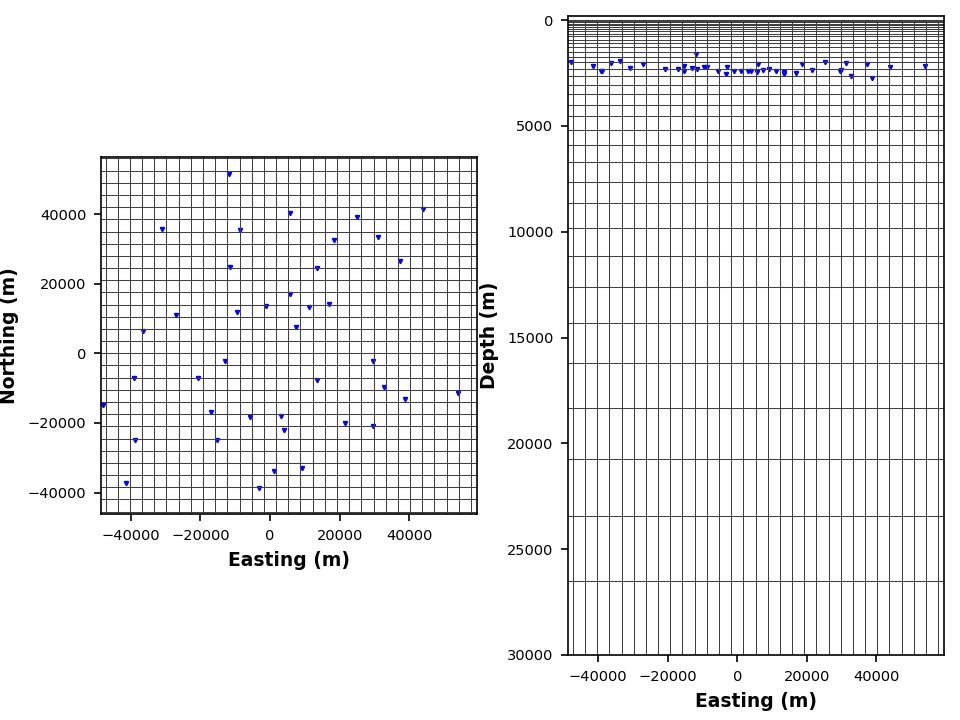

Plotting PlotMesh

In [34]:
model_mesh.cell_size_east = 3500
model_mesh.cell_size_north = 3500
model_mesh.z1_layer = 50
model_mesh.z_target_depth = 30000
model_mesh.n_layers = 40
model_mesh.make_mesh()
model_mesh.plot_mesh(fig_num=8, plot_station_id=False)

## Estimating Starting Half Space

The starting half-space is important because it provides the inversion with a decent starting point. Therefore, in practice it is a good idea to estimate what a good starting resistivity is.  Here we will take the average and median of all apparent resistivity values across the survey.  From this 100 is a good choice, which is a common starting resistivity.

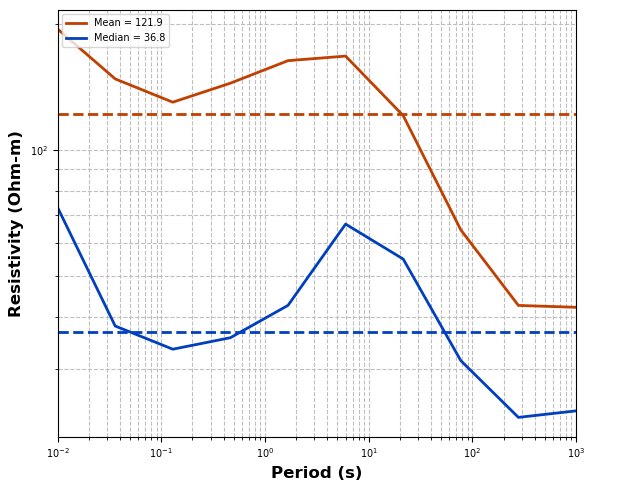

In [25]:
interp_mt_data.estimate_starting_rho()

## Write Model File

We have a decent mesh, lets write to a file

In [30]:
model_mesh.model_fn

WindowsPath('C:/Users/jpeacock/OneDrive - DOI/Documents/GitHub/mt_examples/notebooks/mtpy/ModEM_Model_File.rho')

In [31]:
model_mesh.write_model_file(
    **{"model_fn": Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_sm02.rho"), 
       "res_initial_value":100},
)

2022-10-15T14:29:52 [line 890] Model.write_model_file - INFO: Wrote file to: C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\ynp_sm02.rho


## Covariance 

ModEM uses a regularization parameter called covariance, which controls how smooth the inversion should be, with higher values being more smooth and lower values being coarser.  You can apply the covariance multiple times if you like, so sometimes it is adventageous to use a smaller covariance value but apply it multiple times.  The covariance in ModEM sort of describes the length of smoothing, in that it uses the a certain number of cells depending on the value.  At the padding cells this can blowup and provide unrealistic values and are usually ignored in plotting.  Varying the covariance is an excersize in itself.  For this we will apply a common covariance of 0.3 in all directions just once.

In [35]:
covariance = Covariance(grid_dimensions=model_mesh.res_model.shape)
covariance.write_covariance_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_covariance.cov")
)

2022-10-15T14:39:41 [line 215] Covariance.write_covariance_file - INFO: Wrote covariance file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\ynp_covariance.cov


## Control Files

How ModEM computes the forward model and how the inversion runs can be controlled through control files.  These are often kept to the default values, you may change the starting lambda depending on your modeling method.

In [36]:
control_fwd = ControlFwd()
control_fwd.write_control_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "control.fwd")
)

Wrote ModEM control file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\control.fwd


In [37]:
control_inv = ControlInv()
control_inv.write_control_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "control.inv")
)

Wrote ModEM control file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\control.inv


### Adding Topography

For topographically extreme areas it can be useful to include topography into the model.  We just need to provide an ascii elevation file formatted in the form ArcGIS.  More formats will be supported in the future, but these are relatively common for coarse topography.  You can download DEMs from [https://www.ncei.noaa.gov/maps/grid-extract/](https://www.ncei.noaa.gov/maps/grid-extract/).  One is provided for this data set.  

**Note**: If you are including topography in the model, you need to center the stations to the model cell, otherwise weird things can happen.  

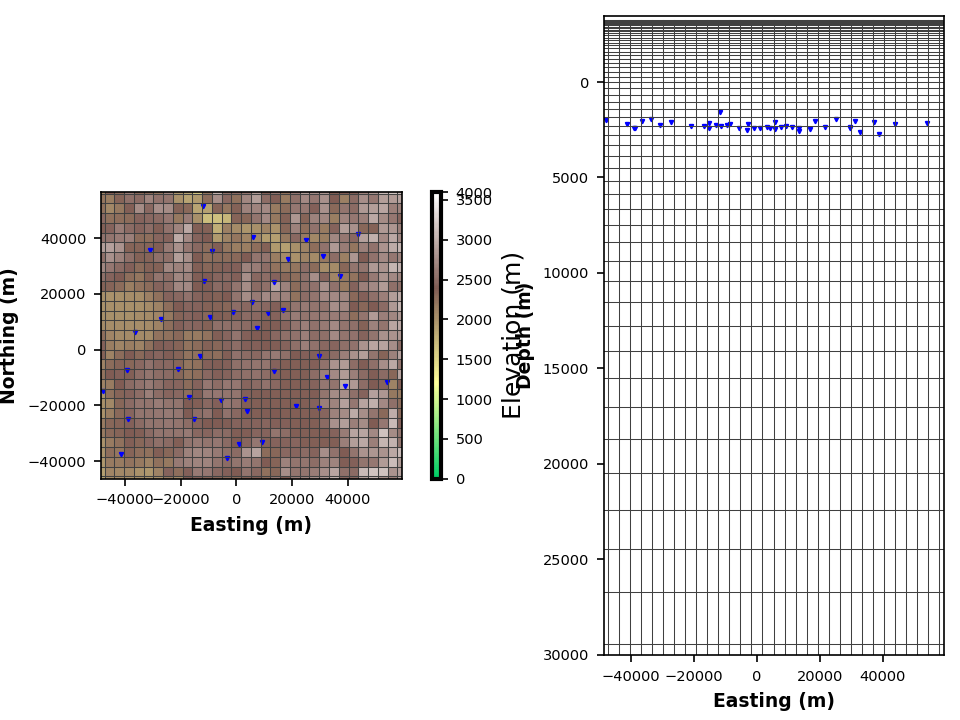

2022-10-15T14:46:15 [line 890] Model.write_model_file - INFO: Wrote file to: C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\ynp_sm02_topo.rho


In [38]:
model_mesh.n_air_layers = 15
model_mesh.add_topography_to_model(
    Path().cwd().parent.parent.joinpath("data", "modeling", "yellowstone.asc"),
    airlayer_type="log_down"
)
model_mesh.plot_mesh(fig_num=10)
model_mesh.write_model_file(
    **{"model_fn": Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_sm02_topo.rho"), 
       "res_initial_value":100},
)

### Write Topography Covariance

Now that topography is added into the model we want to make sure the air cells remain locked.

In [39]:
topo_covariance = Covariance(grid_dimensions=model_mesh.res_model.shape)
topo_covariance.write_covariance_file(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_covariance.cov"),
    model_fn=model_mesh.model_fn,
)

2022-10-15T14:46:55 [line 215] Covariance.write_covariance_file - INFO: Wrote covariance file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\ynp_covariance.cov


## Centering Station and Projecting on to Topography

We need to now center the stations to their cell and project the station to the topgraphic surface.

In [42]:
interp_mt_data.center_stations(model_mesh)
interp_mt_data.project_stations_on_topography(model_mesh)
interp_mt_data.station_locations

station   latitude   longitude  elevation datum_epsg           east  \
0     WYYS1  44.718500 -110.638000   2423.450       4326  528670.497892   
1     WYYS2  44.396350 -110.577000   2399.188       4326  533687.076364   
2    YNP01S  44.742639 -111.260583   2017.630       4326  479370.312946   
3    YNP02S  44.916667 -111.015472   2246.020       4326  498778.785861   
4    YNP03B  45.058972 -110.773333   1587.590       4326  517846.465206   
5    YNP04B  44.653278 -111.084722   2037.310       4326  493282.443984   
6    YNP05S  44.696556 -110.967917   2079.350       4326  502541.968724   
7    YNP06S  44.819056 -110.770444   2293.950       4326  518149.344183   
8    YNP07B  44.915333 -110.732750   2217.660       4326  521094.386236   
9    YNP08S  44.958361 -110.549583   2076.330       4326  535525.427049   
10   YNP09S  44.356667 -111.305833   1918.180       4326  475627.446066   
11   YNP10S  44.531444 -111.118000   2415.230       4326  490624.308664   
12   YNP11S  44.532444 -110.888000   2315.760       4326  508898.808980   
13   YNP13B  44.703167 -110.744028   2235.970       4326  520278.421898   
14   YNP14S  44.748833 -110.552056   2449.520       4326  535458.781641   
15   YNP15S  44.886722 -110.389611   2051.420       4326  548202.685025   
16   YNP16S  44.947028 -110.305500   1961.620       4326  554787.641261   
17   YNP18B  44.260361 -111.146528   2189.760       4326  488303.760013   
18   YNP19B  44.372556 -111.113972   2405.130       4326  490919.750005   
19   YNP20B  44.444472 -110.839500   2311.090       4326  512771.493389   
20   YNP21S  44.576056 -110.788389   2240.820       4326  516800.723637   
21   YNP22S  44.663806 -110.530222   2369.380       4326  537241.563434   
22   YNP23S  44.714333 -110.483194   2382.390       4326  540934.080480   
23   YNP24S  44.721972 -110.412194   2477.070       4326  546551.580397   
24   YNP25S  44.814861 -110.454417   2544.900       4326  543138.570743   
25  YNP26aB  44.894889 -110.229667   2018.790       4326  560824.964814   
26   YNP27B  44.966583 -110.067556   2201.020       4326  573533.599983   
27   YNP28S  44.147917 -111.049750   1952.630       4326  496021.260736   
28   YNP29S  44.373111 -110.818972   2400.300       4326  514422.478965   
29   YNP30S  44.432333 -110.697944   2388.210       4326  524040.495870   
30   YNP31B  44.434722 -110.587778   2381.850       4326  532807.288569   
31   YNP32S  44.526139 -110.457083   2428.170       4326  543141.377237   
32   YNP34S  44.573861 -110.254333   2408.900       4326  559203.961775   
33   YNP35S  44.832556 -110.152333   2086.450       4326  567003.421431   
34   YNP36S  44.133333 -110.820194   2167.740       4326  514383.428657   
35   YNP37S  44.247194 -110.667778   2524.320       4326  526524.789240   
36   YNP38B  44.291194 -110.614556   2400.100       4326  530751.129943   
37   YNP40B  44.505528 -110.215722   2641.260       4326  562342.464431   
38   YNP43S  44.164111 -110.664000   2211.160       4326  526864.141836   
39   YNP45S  44.406333 -110.254194   2358.990       4326  559384.745537   
40   YNP46S  44.474278 -110.138528   2729.910       4326  568515.258549   
41   YNP47B  44.488500 -109.946361   2154.660       4326  583778.476381   
42   YNP50S  44.413056 -110.356944   2362.400       4326  551197.406834   
43   YNPXLS  44.298056 -110.512917   2294.420       4326  538855.458792   
44    SR990  44.463100 -111.228700   1979.200       4326  481807.400155   

           north utm_epsg  model_east  model_north  model_elev  
0   4.951744e+06    32612         0.0      12250.0    2423.450  
1   4.915983e+06    32612      3500.0     -22750.0    2399.188  
2   4.954395e+06    32612    -49000.0      15750.0    2017.630  
3   4.973693e+06    32612    -31500.0      36750.0    2246.020  
4   4.989526e+06    32612    -10500.0      50750.0    1587.590  
5   4.944439e+06    32612    -35000.0       5250.0    2037.310  
6   4.949243e+06    32612    -28000.0      12250.0    2079.350  
7   4.962876e+06    32612    -105

In [43]:
interp_mt_data.to_modem_data(
    Path().cwd().parent.parent.joinpath("data", "modeling", "ynp_z05_t02_topo.dat"),
    topography=True
)

2022-10-15 14:50:26,140 [line 676] mtpy.modeling.modem.data.Data.write_data_file - INFO: Wrote ModEM data file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\modeling\ynp_z05_t02_topo.dat


WindowsPath('C:/Users/jpeacock/OneDrive - DOI/Documents/GitHub/mt_examples/data/modeling/ynp_z05_t02_topo.dat')

In [44]:
mc.close_collection()

2022-10-15 14:50:40,901 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mt_examples\data\transfer_functions\yellowstone_mt_collection.h5
